In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import uproot
import mplhep
import numpy as np
import os
import pandas as pd
import math

plt.style.use(mplhep.style.ROOT)

In [97]:
dblib_path = "/home/ram2aq/ldmx/db-gen-lib/out/electron_tungstensiliconcopperleadoxygen_MaxE_6.0_MinE_6.0_RelEStep_0.1_UndecayedAP_mA_0.1_run_3000"
csv_path = dblib_path + ".csv"

dblib = pd.read_csv(csv_path)

z_name = {74: 'tungsten', 14: 'silicon', 29: 'copper', 82: 'lead', 8: 'oxygen'}
name_z = {'tungsten': 74, 'silicon': 14, 'copper': 29, 'lead': 82, 'oxygen': 8}

# because tungsten does not work at 7.2 GeV, remove it
dblib = dblib[dblib['target_Z'] != 74]

def add_extra_columns(df):
    df['target'] = df['target_Z'].map(z_name)
    
    df["ap_energy"] = df["centerMomentum_energy"] - df["recoil_energy"]
    df["ap_px"] = df["centerMomentum_px"] - df["recoil_px"]
    df["ap_py"] = df["centerMomentum_py"] - df["recoil_py"]
    df["ap_pz"] = df["centerMomentum_pz"] - df["recoil_pz"]

    df["recoil_pt"] = np.sqrt(df["recoil_px"]**2 + df["recoil_py"]**2)
    df["ap_pt"] = np.sqrt(df["ap_px"]**2 + df["ap_py"]**2)
    df["recoil_phi"] = np.arctan2(df["recoil_py"], df["recoil_px"])
    df["ap_phi"] = np.arctan2(df["ap_py"], df["ap_px"])
    df["recoil_theta"] = np.arctan2(df["recoil_pt"], df["recoil_pz"])
    df["ap_theta"] = np.arctan2(df["ap_pt"], df["ap_pz"])
    
add_extra_columns(dblib)

In [100]:
scaledlib_prefix = "/home/ram2aq/ldmx/G4DarkBreM_mod/scaled"
scaledlibs = {}
scaledEnergies = ["8.0", "7.2", "6.48"]
for energy in scaledEnergies:
    temp = []
    for material in dblib['target'].unique():
        expected = scaledlib_prefix + "/electron_" + material + "_scaled_" + energy + "to6.csv"
        if os.path.isfile(expected):
            temp.append(pd.read_csv(expected))
    scaledlibs[energy] = pd.concat(temp)
    add_extra_columns(scaledlibs[energy])

In [111]:
dblib[dblib['target']=='copper']['recoil_energy']

13466    1.621220
13467    0.001275
13468    3.020560
13469    2.856490
13470    0.025348
           ...   
21180    3.187690
21181    1.348120
21182    2.159780
21183    1.446140
21184    1.353690
Name: recoil_energy, Length: 7719, dtype: float64

In [98]:
def bin_df(df, **kwargs): # copied from https://github.com/tomeichlersmith/ldmx-sim-technique/blob/main/ana/dev.ipynb
    w = np.empty(len(df))
    w.fill(1./len(df))
    if 'weights' not in kwargs:
        kwargs['weights'] = w
    cumulative = kwargs.get('cumulative', False)
    if cumulative:
        del kwargs['cumulative']
    v, b = np.histogram(df, **kwargs)
    if cumulative:
        v = np.cumsum(v)
    return v, b

def by_target_mat(df, **kwargs):
    binned = {}
    col_name = kwargs.get('col_name', None)
    if col_name != None:
        del kwargs['col_name']
    callback = kwargs.get('callback', None)
    if callback != None:
        del kwargs['callback']
    for material in df['target'].unique():
        if len(df[df['target']==material]) == 0: continue
        if col_name != None:
            binned[material] = bin_df(df[df['target']==material][col_name], **kwargs)
        elif callback != None:
            binned[material] = bin_df(callback(df[df['target']==material]), **kwargs)
    return binned

def divide_scaled_by_true(**kwargs):
    true_binned = by_target_mat(dblib, **kwargs)
    
    scaled = {}
    for energy in scaledlibs.keys():
        binned = by_target_mat(scaledlibs[energy], **kwargs)
        for material in binned.keys():
            if material not in scaled:
                scaled[material] = {}
            scaled[material][energy] = np.divide(binned[material][0], true_binned[material][0])
    return binned, scaled

In [110]:
e_beam = 6.0
m_aprime = 0.1

def plot_by_material(binned, xlabel="", ylabel="", scaled=None, ylim=None):
    fig, axes = plt.subplots(ncols = 1, nrows = len(binned), sharex = 'col', layout='constrained')
    for i, (material, (vals, bins)) in enumerate(binned.items()):
        ax = axes[i]
        ax.text(0.9, 0.25, material, horizontalalignment='right', 
                verticalalignment='top', transform=ax.transAxes)
        if ylim != None:
            ax.set_ylim(ylim)
        if scaled == None:
            
            ax.hist(bins[:-1], bins, weights=vals, histtype='step', color='black',
                    label='unscaled MG/ME at {e_beam:.1f} GeV'.format(e_beam=e_beam) if i==0 else '_nolegend_')
        else:
            for energy, scaledVals in scaled[material].items():
                ax.hist(bins[:-1], bins, weights=scaledVals, histtype='step', 
                        label=energy + ' GeV' if i==0 else '_nolegend_')
    
    axes[-1].set_xlabel(xlabel)
    axes[len(axes) // 2].set_ylabel(ylabel, loc='center')
    if scaled == None:
        fig.legend(title="$m_{{A\'}} = {m_aprime:.1f}$ GeV".format(m_aprime=m_aprime), loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        fig.legend(title="$m_{{A\'}} = {m_aprime:.1f}$ GeV\nScaled to\n{e_beam:.1f} GeV from".format(m_aprime=m_aprime,e_beam=e_beam),
                   loc='center left', bbox_to_anchor=(1.0, 0.5))
    return fig, axes

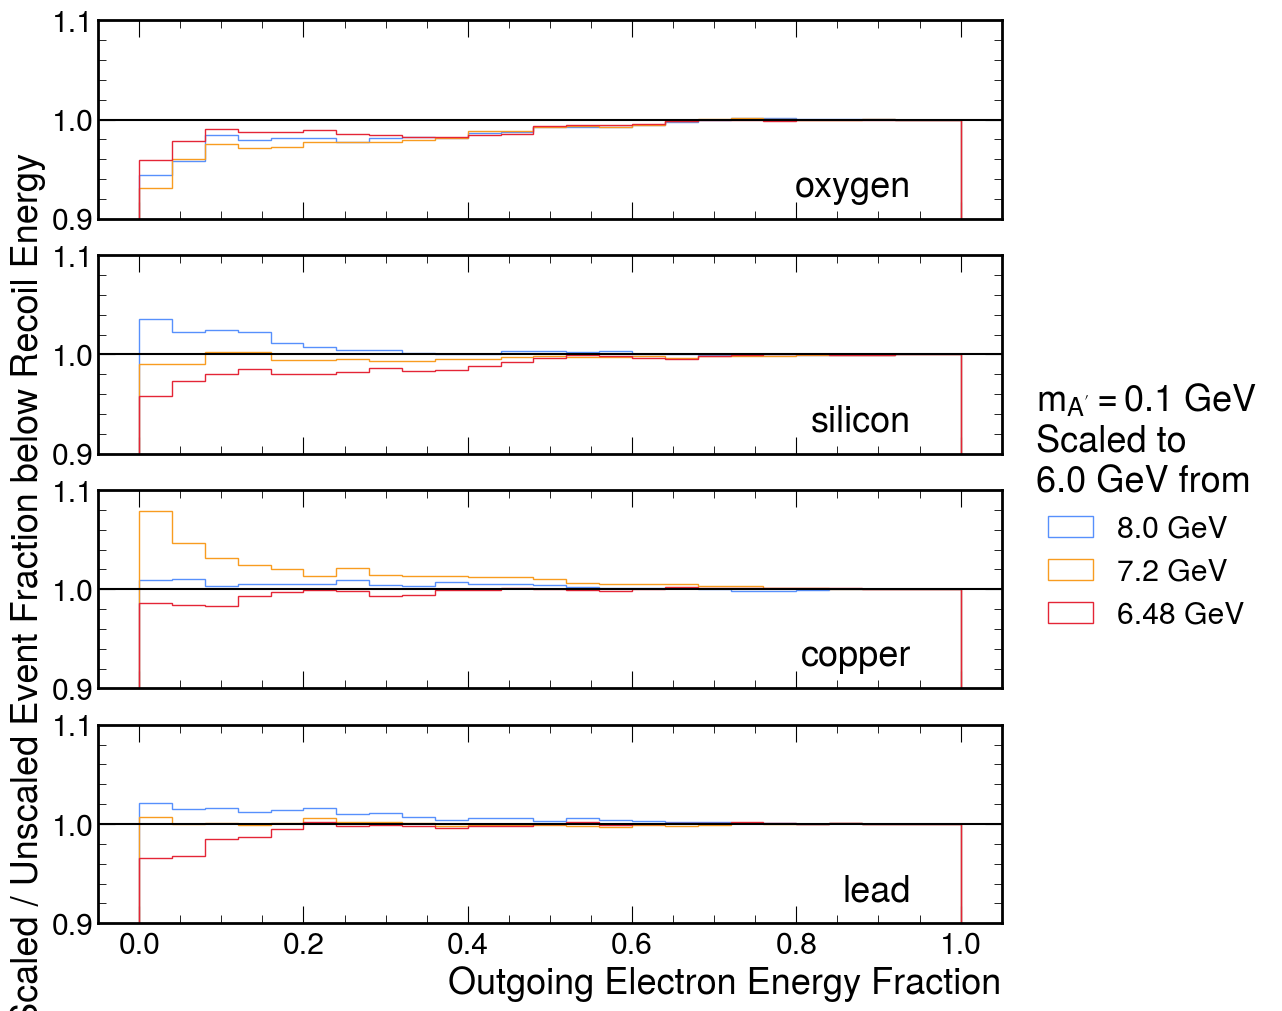

In [111]:
binned, scaled = divide_scaled_by_true(callback=(lambda df: df['recoil_energy']/e_beam), range=(0,1), bins=25, cumulative=True)
fig, axes = plot_by_material(binned, xlabel="Outgoing Electron Energy Fraction", 
                             ylabel="Scaled / Unscaled Event Fraction below Recoil Energy", 
                             scaled=scaled, ylim=(0.9,1.1))

for ax in axes:
    ax.axhline(1.,color='black')
plt.show()

/tmp/ipykernel_405212/1996388505.py:39: RuntimeWarning: invalid value encountered in divide
  scaled[material][energy] = np.divide(binned[material][0], true_binned[material][0])
/tmp/ipykernel_405212/1996388505.py:39: RuntimeWarning: divide by zero encountered in divide
  scaled[material][energy] = np.divide(binned[material][0], true_binned[material][0])


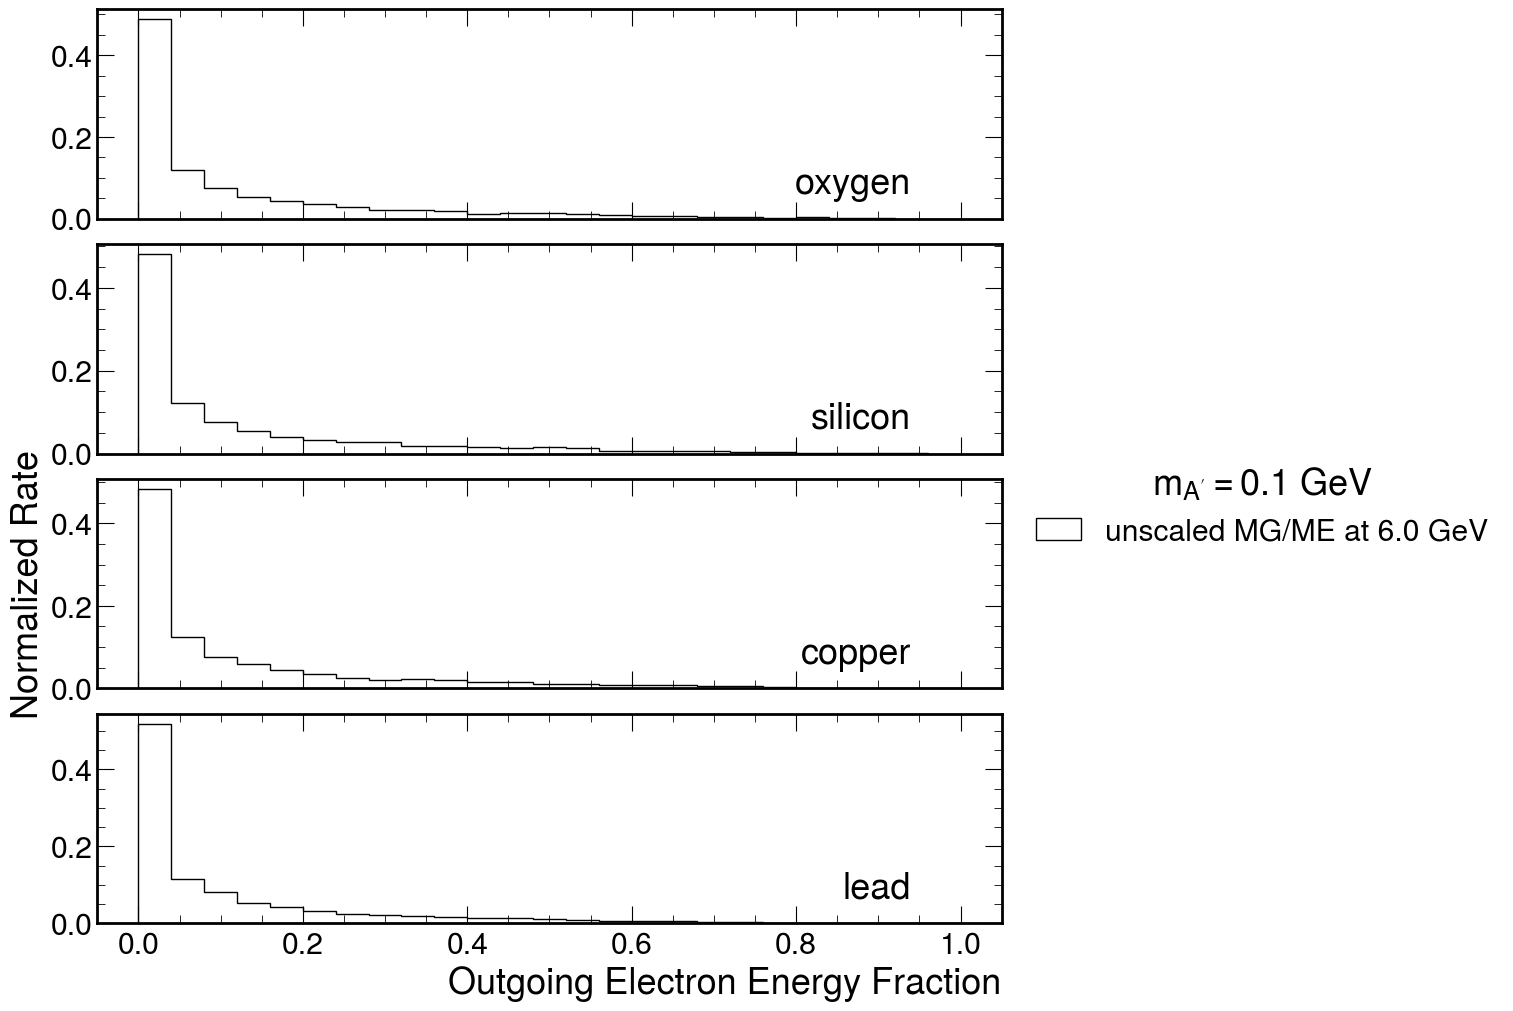

In [ ]:
binned, scaled = divide_scaled_by_true(callback=(lambda df: df['recoil_energy']/e_beam), range=(0,1), bins=25)
fig, axes = plot_by_material(binned, xlabel="Outgoing Electron Energy Fraction", ylabel="Normalized Rate")

for ax in axes:
    ax.set_yscale('log')
#    ax.axhline(1.,color='black')
plt.show()

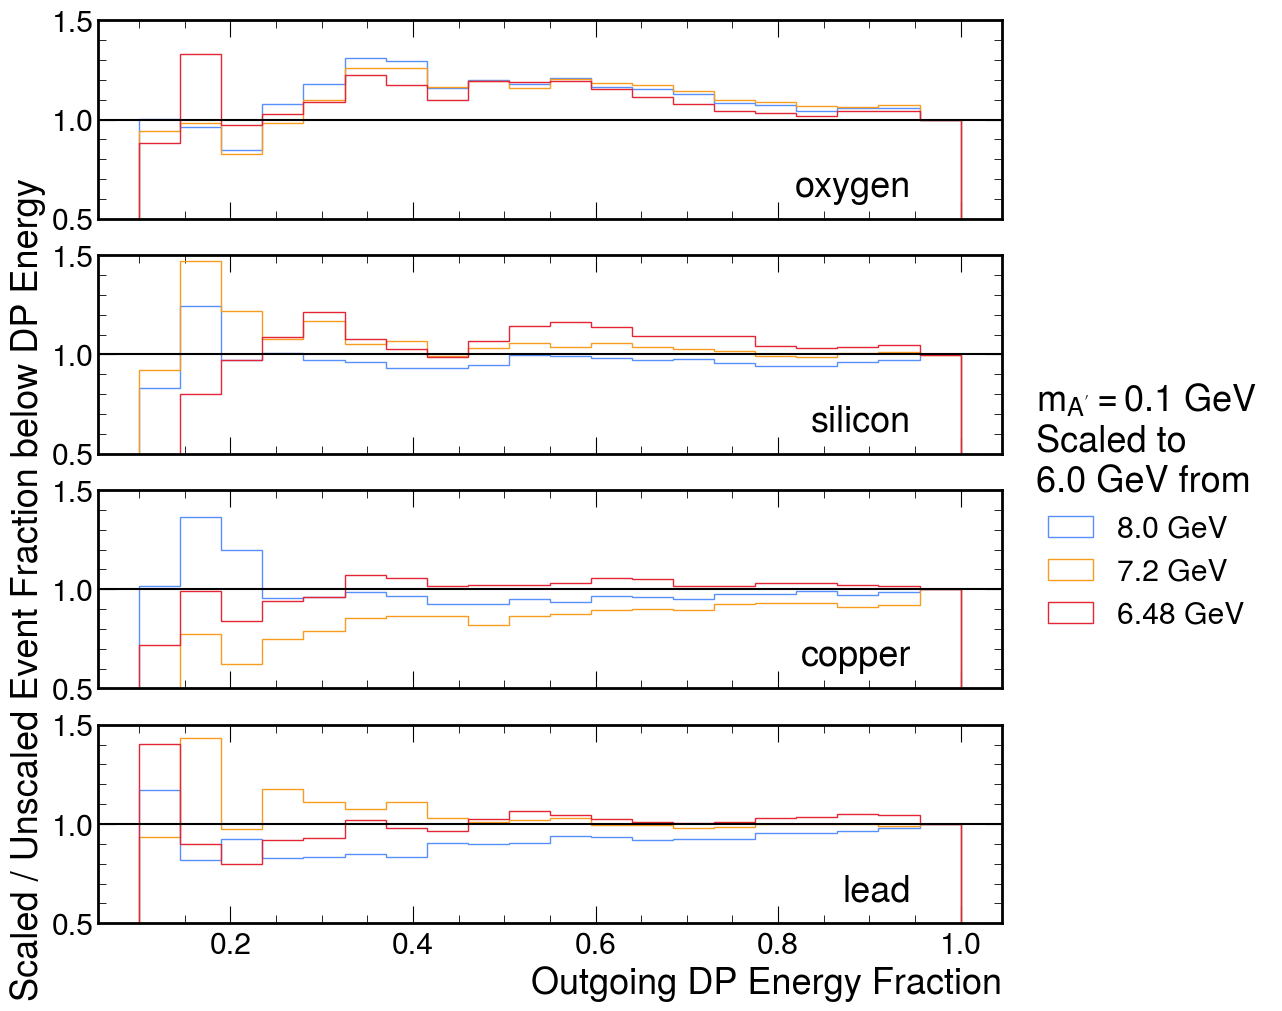

In [84]:
binned, scaled = divide_scaled_by_true(callback=(lambda df: df['ap_energy']/e_beam), range=(0.1,1), bins=20, cumulative=True)
fig, axes = plot_by_material(binned, xlabel="Outgoing DP Energy Fraction", 
                             ylabel="Scaled / Unscaled Event Fraction below DP Energy", 
                             scaled=scaled, ylim=(0.5,1.5))

for ax in axes:
    ax.axhline(1.,color='black')
plt.show()

#plot_by_material(by_target_mat(dblib, callback=(lambda df: np.cos(df['recoil_theta'] - df['ap_theta'])), bins=50), "$\cos(\Delta \\theta_{e,A'})$")

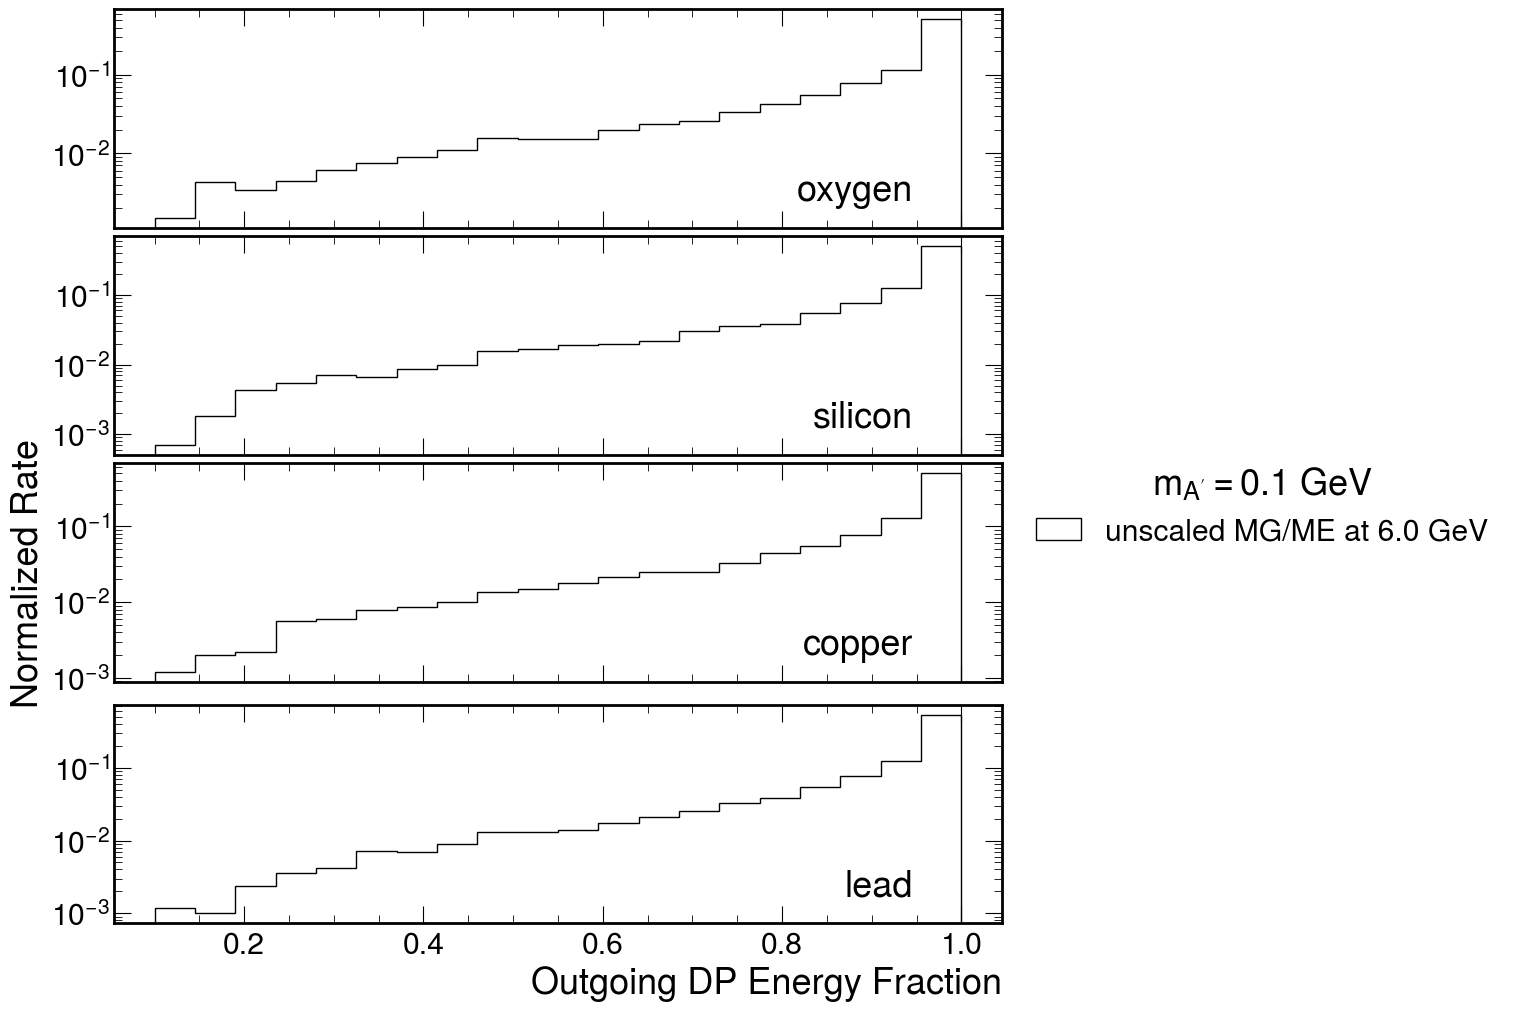

In [124]:
binned, scaled = divide_scaled_by_true(callback=(lambda df: df['ap_energy']/e_beam), range=(0.1,1), bins=20)
fig, axes = plot_by_material(binned, xlabel="Outgoing DP Energy Fraction", 
                             ylabel="Normalized Rate")

for ax in axes:
    ax.set_yscale('log')
plt.show()

#plot_by_material(by_target_mat(dblib, callback=(lambda df: np.cos(df['recoil_theta'] - df['ap_theta'])), bins=50), "$\cos(\Delta \\theta_{e,A'})$")

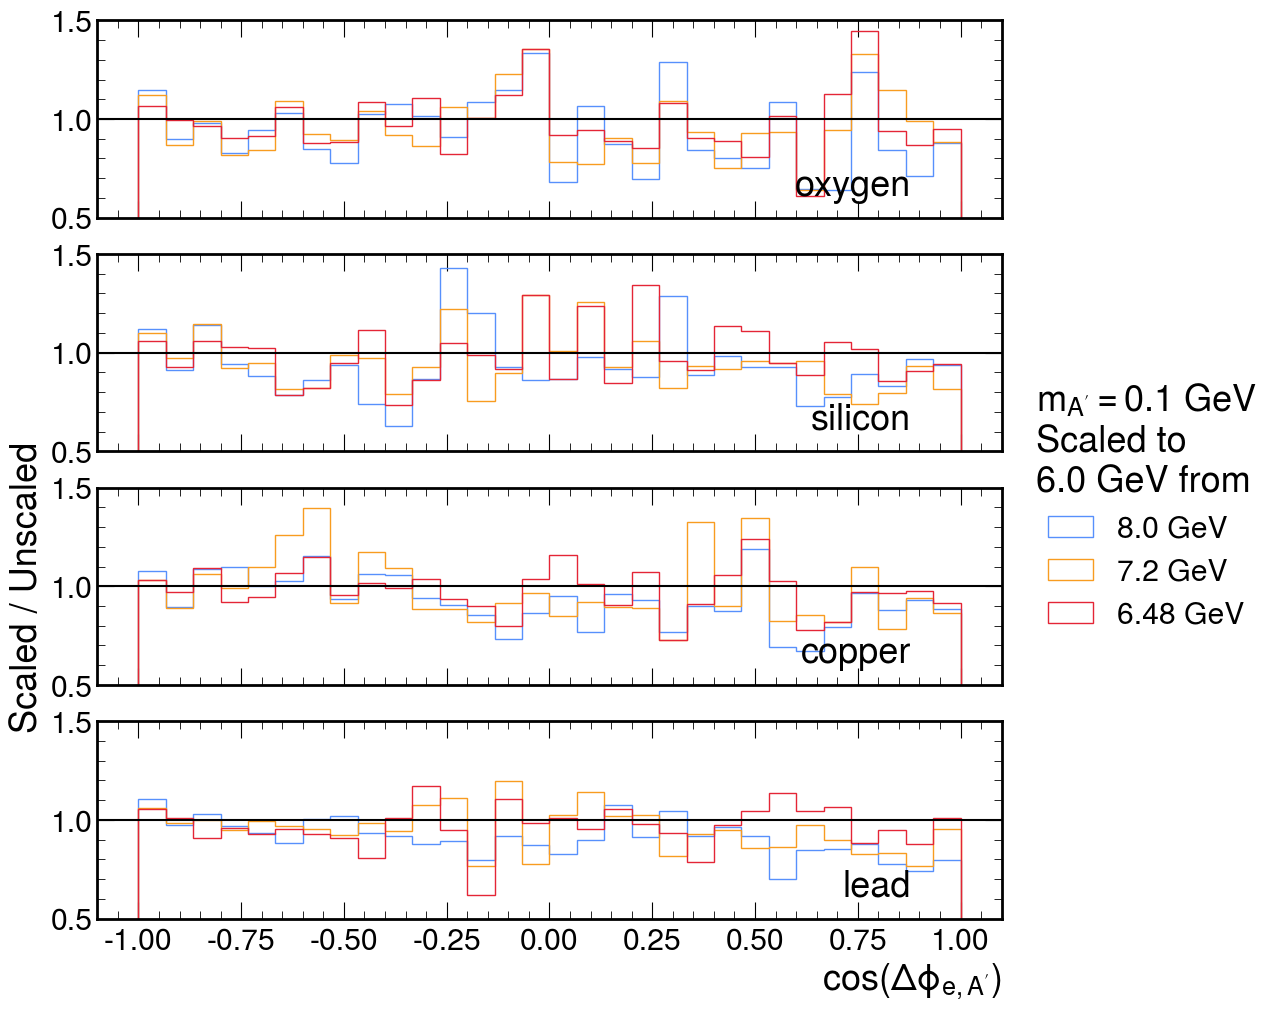

In [82]:
binned, scaled = divide_scaled_by_true(callback=(lambda df: np.cos(df['recoil_phi'] - df['ap_phi'])), range=(-1.0,1.0), bins=30)

fig, axes = plot_by_material(binned, xlabel="$\cos(\Delta \phi_{e,A'})$", ylabel="Scaled / Unscaled", scaled=scaled, ylim=(0.5,1.5))

for ax in axes:
    ax.axhline(1.,color='black')
plt.show()

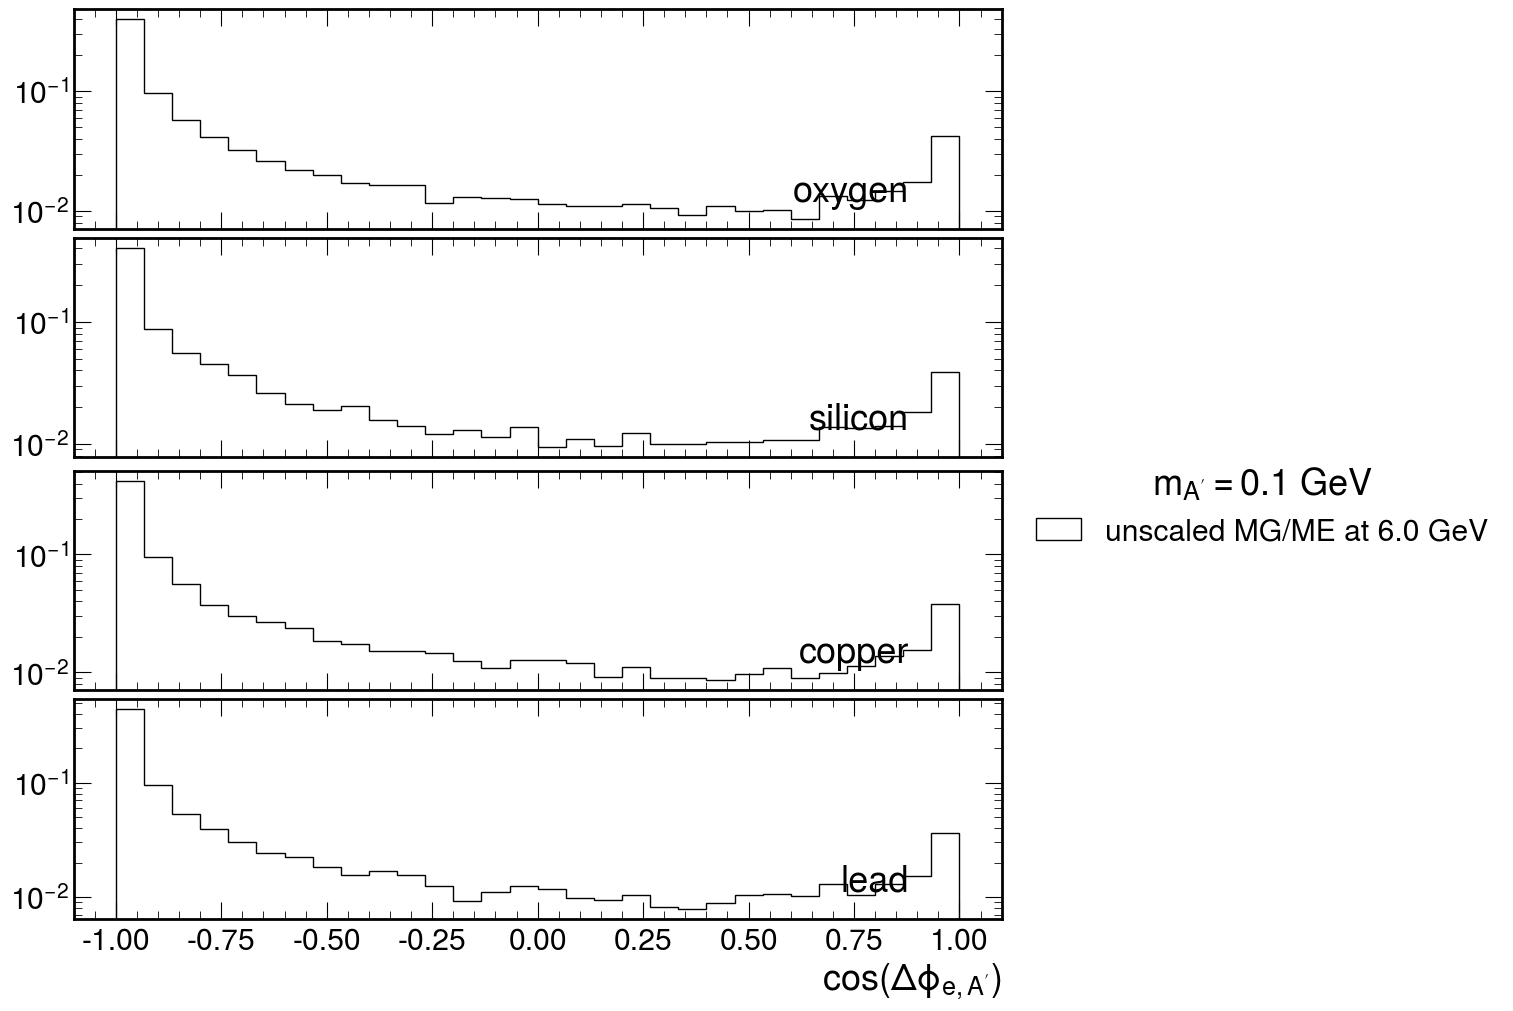

In [121]:
binned, scaled = divide_scaled_by_true(callback=(lambda df: np.cos(df['recoil_phi'] - df['ap_phi'])), range=(-1.0,1.0), bins=30)

fig, axes = plot_by_material(binned, xlabel="$\cos(\Delta \phi_{e,A'})$")

for ax in axes:
    ax.set_yscale('log')
    #    ax.axhline(1.,color='black')
plt.show()

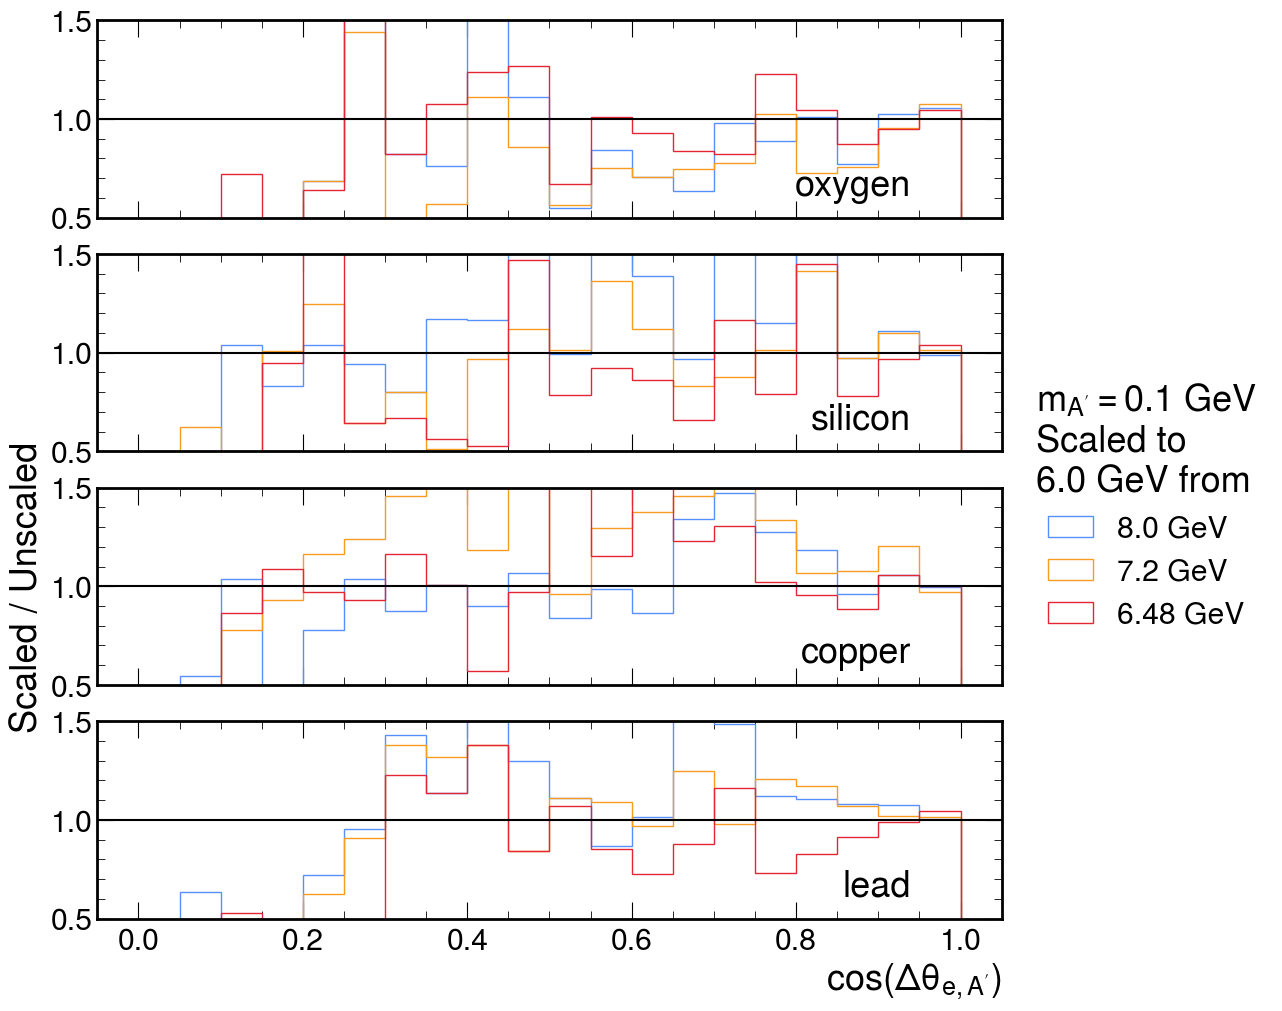

In [116]:
binned, scaled = divide_scaled_by_true(callback=(lambda df: np.cos(df['recoil_theta'] - df['ap_theta'])), range=(0,1.0), bins=20)

fig, axes = plot_by_material(binned, xlabel="$\cos(\Delta \\theta_{e,A'})$", ylabel="Scaled / Unscaled", scaled=scaled, ylim=(0.5,1.5))

for ax in axes:
    ax.axhline(1.,color='black')
plt.show()

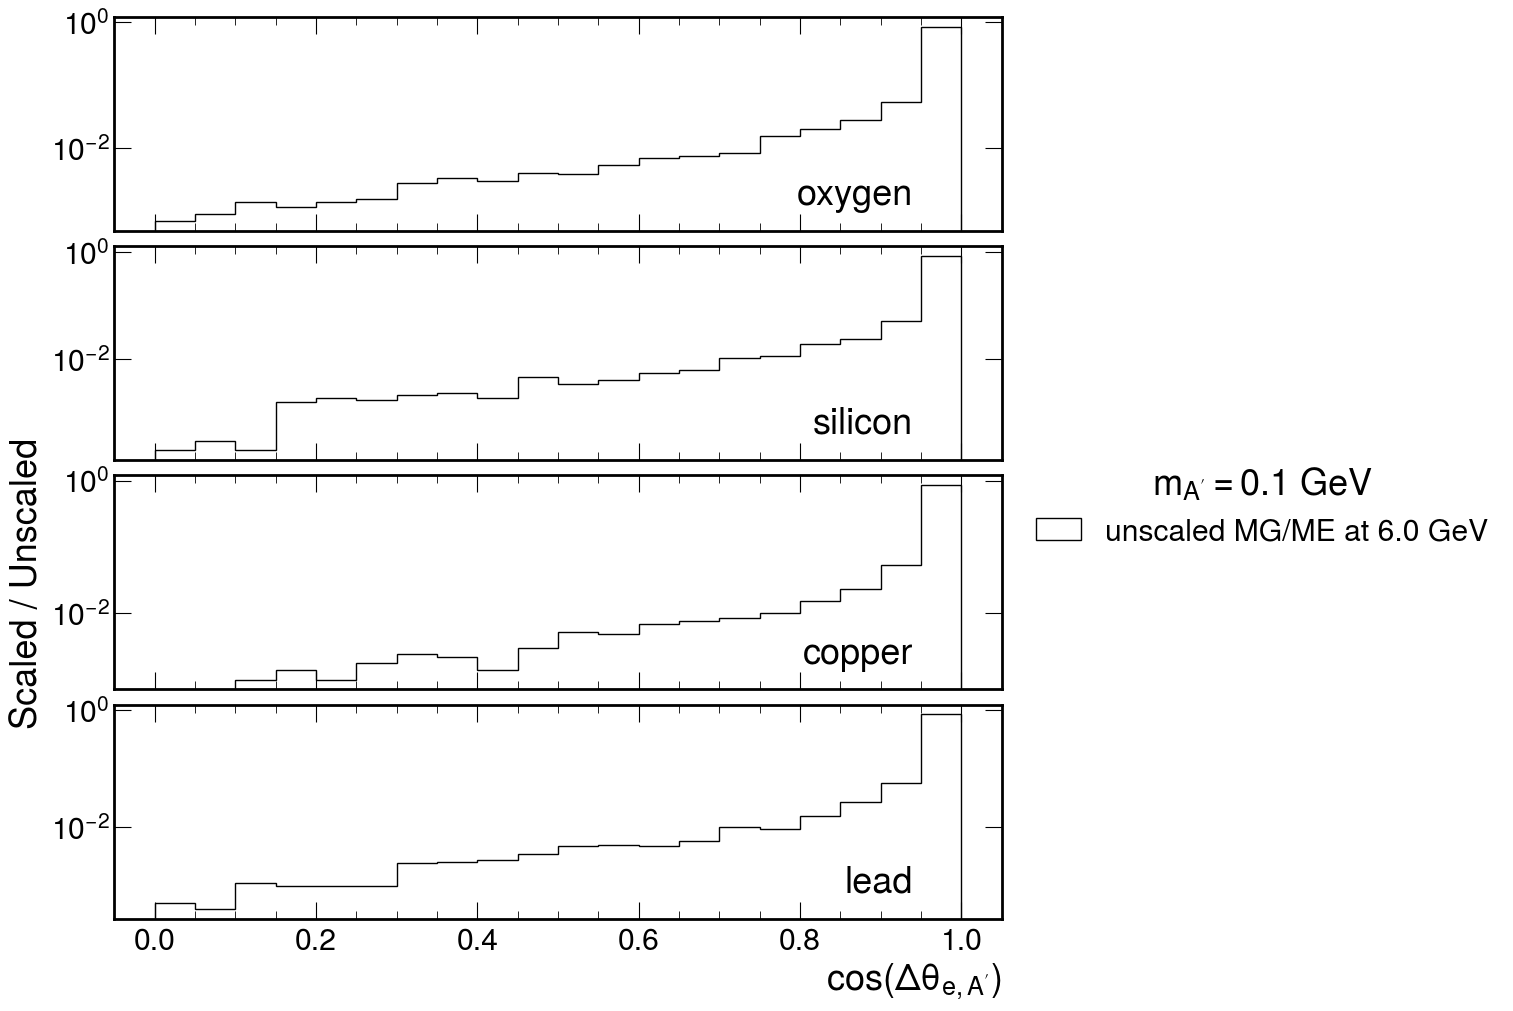

In [122]:
binned, scaled = divide_scaled_by_true(callback=(lambda df: np.cos(df['recoil_theta'] - df['ap_theta'])), range=(0,1.0), bins=20)

fig, axes = plot_by_material(binned, xlabel="$\cos(\Delta \\theta_{e,A'})$", ylabel="Scaled / Unscaled")

for ax in axes:
    ax.set_yscale('log')

plt.show()

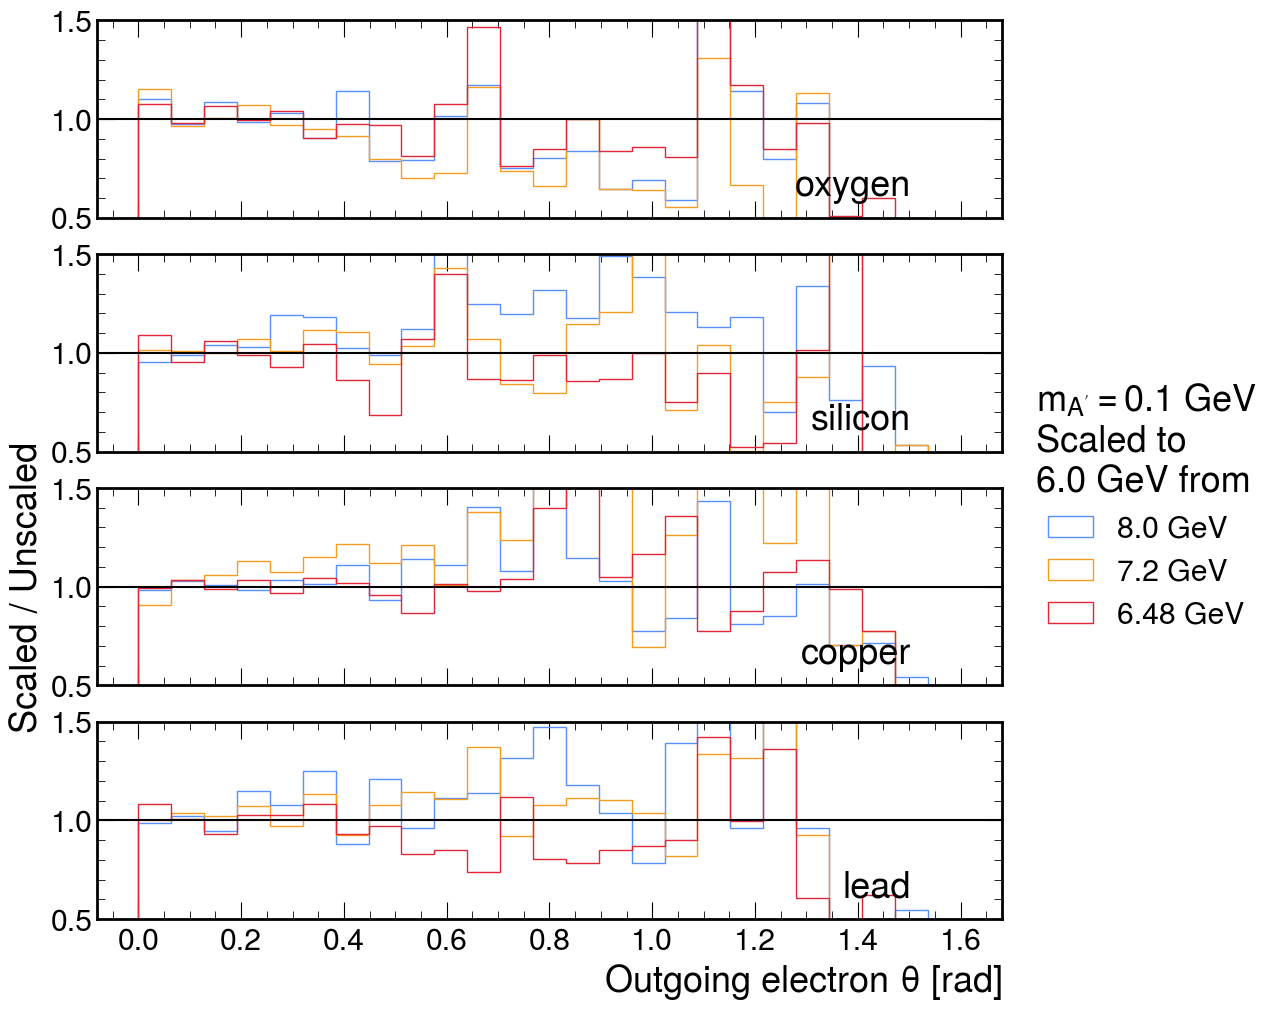

In [90]:
binned, scaled = divide_scaled_by_true(col_name='recoil_theta', range=(0,1.6), bins=25)

fig, axes = plot_by_material(binned, xlabel="Outgoing electron $\\theta$ [rad]", ylabel="Scaled / Unscaled", scaled=scaled, ylim=(0.5,1.5))

for ax in axes:
    ax.axhline(1.,color='black')
plt.show()

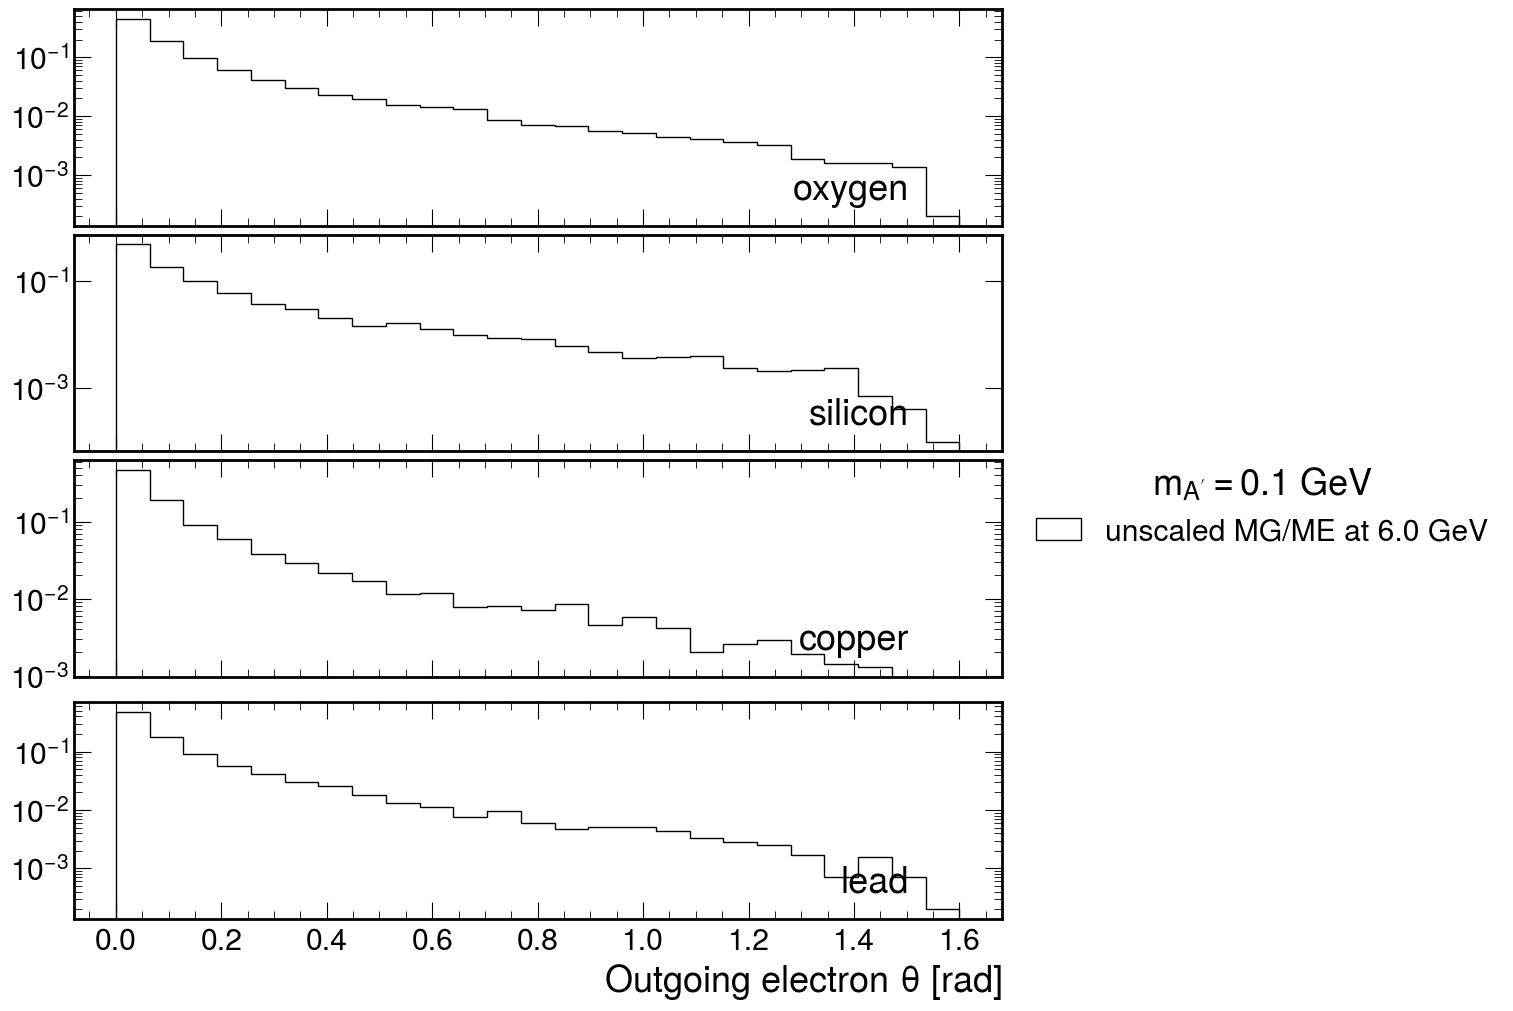

In [123]:
binned, scaled = divide_scaled_by_true(col_name='recoil_theta', range=(0,1.6), bins=25)

fig, axes = plot_by_material(binned, xlabel="Outgoing electron $\\theta$ [rad]")

for ax in axes:
    ax.set_yscale('log')
plt.show()

In [104]:
def hist2d_by_material(df, xcol, ycol, ncols, xlabel="", ylabel="", bins=50, logX=False, logY=False):
    mats = df['target'].unique()
    fig, axes = plt.subplots(nrows = math.ceil(len(mats) / ncols), ncols=ncols, constrained_layout=True)
    for j in range(len(mats), math.ceil(len(mats) / ncols) * ncols):
        fig.delaxes(axes[j // ncols][j % ncols])
    for i, material in enumerate(mats):
        ax = axes[i // ncols, i % ncols]
        if logX:
            ax.set_xscale('log')
        if logY:
            ax.set_yscale('log')
        ax.hist2d(df[df['target']==material][xcol], df[df['target']==material][ycol], bins=bins, density=True)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(material)
    return fig, axes

(<Figure size 1000x1000 with 5 Axes>,
 array([[<Axes: title={'center': 'oxygen'}, xlabel='Recoil e $p_T$', ylabel="A' $p_T$">,
         <Axes: title={'center': 'silicon'}, xlabel='Recoil e $p_T$', ylabel="A' $p_T$">,
         <Axes: title={'center': 'copper'}, xlabel='Recoil e $p_T$', ylabel="A' $p_T$">],
        [<Axes: title={'center': 'tungsten'}, xlabel='Recoil e $p_T$', ylabel="A' $p_T$">,
         <Axes: title={'center': 'lead'}, xlabel='Recoil e $p_T$', ylabel="A' $p_T$">,
         <Axes: >]], dtype=object))

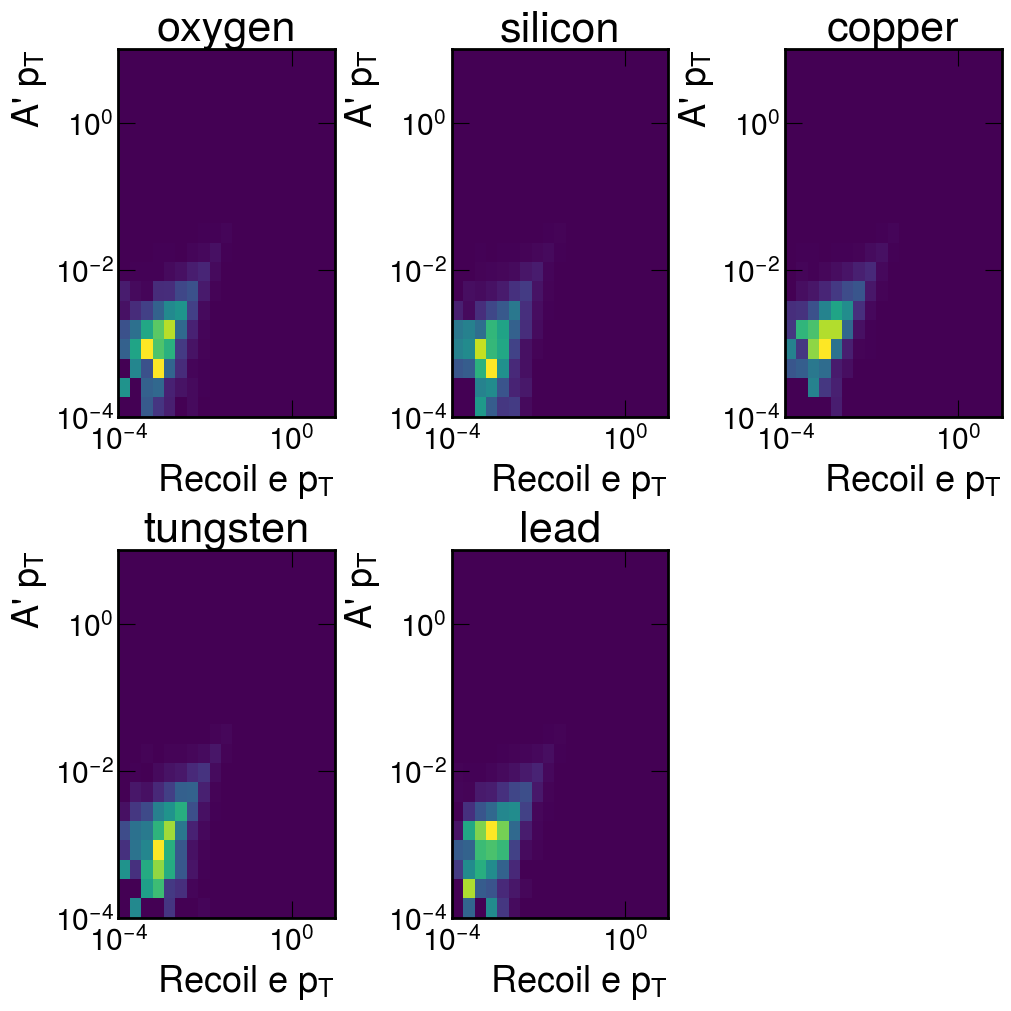

In [107]:
hist2d_by_material(dblib, 'recoil_pt', 'ap_pt', 3, xlabel='Recoil e $p_T$', ylabel="A' $p_T$", bins=np.logspace(-4, 1, 20), logX=True, logY=True)